# Quality control and annotation of sequence data 

## Introduction

A major challenge of biomedical research is the quality control (QC) of sequence data. False positive variant calls and genotyping error can hinder the ability to detect true disease associations or introduce spurious associations, therefore there is a need for rigorous QC. This excercise focuses on QC after variant calling stage and requires a project variant calling format file (pVCF) as input. In our pipelines we have defined default theresholds for genotype and variant-level hard filtering based on the UK Biobank (UKB) recommendations and a thorough review of the literature [[cf. Carson et al. BMC Bioinformatics (2014)](https://doi.org/10.1186/1471-2105-15-125),[cf. Lek et al. Nature (2016)](https://doi.org/10.1038/nature19057),[cf. Szustakowski et al. Nature Genetics (2021)](https://doi.org/10.1038/s41588-021-00885-0)]. 
 
There are different stages of the QC process. First, the QC of the variant sites and genotypes in the VCF file is performed. We have developed a pipeline that uses bcftools and handles: the splitting of multiallellic sites, the left-normalization of indels, the annotation known/novel variants based on dbSNP, it also perfoms genotype and variant-level filtering based on genotype calling qualities and outputs summary statitics (TS/TV ratio) before and after QC to assess its effectiveness. The output is a quality controlled `vcg.gz` file for downstream analysis. At the end of this first stage we have removed low quality variant sites and genotypes.

**Filtering variant sites that do not pass**

The VCF file which you are provided only includes variant sites that have passed, those variants that failed variant quality score recalibration (VQSR) have been removed. If you look at the `FILTER` column, you can observe if a variant passed/failed. If there are variant sites that failed, they should be removed at the start of QC.

**Splitting multi-allelic sites**

A multiallelic site is a position in the genome where two or more alternative alleles are observed. According to 1000 Genomes Project estimates, multiallelic sites account for 2.3% of all autosomal positions that are single nucleotide variants (SNVs) [1000 Genomes Project Consortium et al. Nature (2012)](https://pubmed.ncbi.nlm.nih.gov/23128226/). Since analysis programs, for complex traits, are designed to analyze biallelic loci, those with more than two alleles must be split to form multiple loci each with only two alleles. Therefore, the first step of the QC involves converting multiallelic sites into biallelic loci. 

As an example the following multiallelic row:
```
#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO    FORMAT  SAMPLE1
20      101     .       A       ACCA,TCGG       .       PASS    VC=INDEL;AC=3,2;AF=0.375,0.25;AN=8      GT:AD:DP:GQ:PL  0/1:2,15,31:30:99:2407,0,533,697,822,574
```
Will be converted in these two biallelic loci. Note that the two loci both have the same reference allele. 
```
#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO    FORMAT  SAMPLE1
20      101     .       A       ACCA    .       PASS    VC=INDEL;AC=3;AF=0.375;AN=8;OLD_MULTIALLELIC=20:101:A/ACCA/TCGG GT:AD:DP:GQ:PL  0/1:2,15:30:99:2407,0,533
20      101     .       A       TCGG    .       PASS    VC=INDEL;AC=2;AF=0.25;AN=8;OLD_MULTIALLELIC=20:101:A/ACCA/TCGG  GT:AD:DP:GQ:PL  0/.:2,31:30:99:2407,697,574
```

**Performing normalization**

The Variant Call Format (VCF) is a very flexible file format specification that allows to represent different types of variants including SNV, indels, and structural variants. However, this variant representation is non-unique for variants that have explicitly expressed reference and alternative sequences. Therefore, variant normalization is needed to ensure correcteness. Normalization consists of two steps: parsimony and left alignment. For more information on this topic read this wiki from the [center of statistical genetics](https://genome.sph.umich.edu/wiki/Variant_Normalization)

**Parsimony**

Parsimony is when a variant can be represented in as few nucleotides as possible without reducing the length of any allele to 0. 
The image below shows a representation of a multi nucleotide polymorphism (MNP) represented superfluously by the first 3 cases and a parsimoniously in the 4th case. As you can see from the image in the left side there are four different representations of the variant differentiated by color and in the right side it shows the representation in the VCF file with the 4th being the parsimonious. 

<img src="attachment:ab515aa8-fe35-48f8-bf0b-7f6d434358b4.png" alt="Screenshot" style="width:800px;height:500px;">

**Left alignment**

Left aligning a variant involves shifting the start position of that variant to the left till it is no longer possible to do so. It is a concept associated with insertion and deletion variants and describes specifically the nature of a position of a variant as opposed to its length. In order to further differentiate left alignment from simply left padding a variant, the definition is as follows: `A variant is left aligned if and only if it is no longer possible to shift its position to the left while keeping the length of all its alleles constant.`

<img src="attachment:a5a8fc63-9504-4e9f-845e-6029c86bebe5.png" alt="Screenshot" style="width:800px;height:500px;">

**QC for read-depth, genotype quality and allelic imbalance**

In our pipeline, the default values are as follows: genotypes are set to missing if they have a Genotype Quality (GQ)<20 and a Genotype Depth (DP)<8 for SNVs or DP<10 for indels. Additionally, variants are removed if they are missing > 10% of their data.

**Identifying samples whose genetic sex does not match reported gender**

Sample swaps can occur and although checking genetic sex with reported gender will not totally resolve this issue, it can help to remove samples for which there has potentially been a sample swap. This step is part of standard QC, but it is not performed in this exercise since a small example had to be provided which only includes variant sites from chromosome 21. 

**Identifying duplicate sample and related individuals**

Another step of the QC consists of identifying duplicated samples and related individuals within the dataset. In this example we used KING to identify duplicate samples. If observed only one of the individuals should be retained.  We also check for related individuals since the data will be analyzed later using a generalized linear mixed model (GLMM) framework it is not necessary to removed related individuals. However, this is not true for all analyses, e.g. logistic regression, and only unrelated indivduals should be included in the analysis. Additionally we need to know which individuals are related when principal component (PC) analysis (PCA) is peformed. Testing for deviation from Hardy-Weinberg equilibrium (HWE) should only be performed using unrelated individuals. 

**PCA**

The data set can contain samples which are outliers. This can be due to individuals from different populations that are included in the data or batch effects when the data is generated. PCA is used in the data cleaning process to aid in identifying outliers which are then removed from the dataset. Flashpca will be used for this exercise to perform PCA.

**Testing for deviation from HWE**

Deviation from HWE can denote the presences of genotype error for a variant site. Therefore deviation from HWE is tested for in samples from unrelated individuals same ancestry group. If case-control data is being QC'ed testing is performed in controls. Various threshold are used to determine which variant sites should be removed, e.g., 5 x $10^{-8}$.   

**Evaluating data quality using TS/TV ratios**

One way to assess the effectiveness of the QC is to calculate the transition to transversion (TS/TV) ratio. For human exome sequence data, the TS/TV ratio is ~3.0 and ~2.0 outside of exome regions. However, the TS/TV ratio varies between synonymous vs nonsynonymous SNVs, and haploid vs diploid chromosomes. The TS/TV ratios can be calculated throughout the QC process to evaluate the impact of data cleaning. It should always be calculated at the end of the QC process to determine if the QC was sufficient. For more information refer to [Wang et al. Bioinformatics (2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4308666/).

**Annotation**

After QC the variant sites are annotated with information that includes location, gene boundries, minor allele frequencies (MAF), variant type, and function. This information is used in the downstream analysis. 

## Data

The following section describes the download of the publicly available sequence data from 1000 Genomes and the creation of a minimal working example (MWE) that contains data from 534 European individuals. 

Please note that this is an example and usually much larger sample sizes and all the autosomes would undergo QC.

The analyses applied to these data will be:

1. Sequence data quality control: VCF_QC.ipynb
2. Relatedness and detection of cryptic duplicates analysis using KING
3. Principal Components Analysis (PCA) to detect outliers
4. Testing for deviation from HWE
5. Evaluating TS/TV ratios
6. Annotation of variants: annovar.ipynb

### A. Generation of minimal working example (MWE)

We move this section to supplementary.

**Please note: you do not have to run this part as this is just illustrating how the MWE was created, the data will be given to you ready for analysis**

### B. Generate summary statistics for the vcf file before running the VCF_QC pipeline

In [ ]:
bcftools stats ./data/vcf_qc_mwe_sorted.vcf.gz > ./vcf_qc_mwe_sorted.stats

Take a look at the start of that file and see how many samples, variant sites (SNVs, indels, multiallelic sites) are included in this vcf file.

In [4]:
cat ./vcf_qc_mwe_sorted.stats | grep  "^SN"

SN	0	number of samples:	534
SN	0	number of records:	150000
SN	0	number of no-ALTs:	0
SN	0	number of SNPs:	135074
SN	0	number of MNPs:	0
SN	0	number of indels:	17112
SN	0	number of others:	0
SN	0	number of multiallelic sites:	14884
SN	0	number of multiallelic SNP sites:	3380


Another QC metric is the TS/TV ratio, which can be evaluated throughout the QC process. It is always necessary to check the TS/TV ratios at the last QC step to determine if the QC performed was sufficient.

In [5]:
cat ./vcf_qc_mwe_sorted.stats | grep "^TSTV"

TSTV	0	88922	50010	1.78	85743	46266	1.85


# Step 1. Run the quality control (QC) on the VCF file. 

QC is performed to remove genotypes that could be incorrect and remove variant sites which may be false positives. Generally speaking the QC happens at different levels.

1. **Genotype QC:** genotypes that have read depth (DP) lower than 8 for SNPs and below 10 for indels and have genotype quality (GQ) below 20 are set to missing.

2. **Variant QC:** variants with more than 10% of their genotypes missing are removed. In this step many researchers choose to be more stringent removing those with more than 5% missing genotypes or some decide to allow for higher missingess rate (20%). In this step it is also recommended to remove monomorphic variants.

3. **Sample QC:** in this step samples missing greater than 10% of their genotypes are removed, because it could indicate a problem with sample quality. Please note, if you are working with exome data, you should be sure to take the intersect of the capture arrays.


The goal of this section is to generate a `vcf.gz` file which has undergone QC to be used later for downstream analysis. 

QC includes:
- Multiallelic splitting, left-alignment and normalization (`bcftools norm`).
- Determine if the REF alleles matches the reference (`bcftools norm`).
- Genotype and variant level filtering based on genotype calling qualities (`bcftools filter`).
- Known and novel variant annotation (`bcftools annotate`).
- Summary statistics, including TS/TV ratio (`bcftools stats`).


### A note on TS/TV ratios

`bcftools stats` command provides useful statistics to look at such as for example, the number of samples in the vcf file, the number of SNPs, indels, multiallelic sites, the transitions to transversion (TS/TV) ratio, the allele frequency distribution using the non-reference allele, the substitutions types, and the genotype depth (DP) distribution. 

1. Sample level TS/TV ratio: bcftools looks at each variant site to determine if a TS or TV has ocurred, counts the number of each occurrence and takes the ratio.

2. Individual level TS/TV ratio: bcftools determines for each heterozygous genotype if a TS or TV has ocurred. The number of TS and TV are counted and the ratio is obtained.

3. Sample level TS/TV ratio: snpsift takes the average of the individual TS/TV ratio

Therefore the TS/TV ratio obtained from bcftools will not necessarily equal the TS/TV ratio obtained from SnpSift

It should be noted that for the sample level TS/TV bcftools simply counts the TS and TV event for observed SNPs in the data. Other tools, such as `SnpSift`, implements variant level TS/TV by counting TS and TV events in sample genotypes and compute the ratio after summing up TS and TV across all samples. See [here](https://github.com/samtools/bcftools/issues/1526) some discussions on this issue.

### Input files

1. The target `vcf.gz` file
    - Run `rename_chrs` workflow to add `chr`, if only the chromosome number is provided, and it does not have the `chr` prefix, in order that it matches with reference `fasta` file.
    - The vcf.gz file needs to be compressed by bgzip, instead of simple gzip
    - It should have a index file accompanying it. The index file can be generated by tabix
    - It must be a valid vcf.gz file that can pass bcftools sanity check: i.e. all tags are defined properly
    - It must contains following fields:
        1. ##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Approximate read depth (reads with MQ=255 or with bad mates are filtered)">
        2. ##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
 
2. dbSNP database in `VCF` format

3. A reference sequence `fasta` file

###  Run the VCF QC using `bcftools` pipeline

For the first step of QC, bcftools is run to remove variant sites which have "failed". As mentioned before, this step will not be performed because all available variant sites have "passed". Then bcftools performs multiallelic splitting and left normalization.  The the bcftools pipeline also removes those genotypes with have a read depth of < 8 for SNVs and read depth of < 10 for indels.  Additionally those genotypes that have a GQ score of < 20 are also made missing. Lastly, those variant sites which are missing >10% of their genotypes are removed.  In order to perform these tasks bcftools does need some annotations which includes which allele is the the reference allele and if a variant is an SNV or indel. **Since this step even with only 150,000 variant sites takes ~15 minutes and uses large amounts of memory the step has been performed for you and the output file is provided.** We provide the command below for your refernence but please do not run it.

The output file is called `./data/output/bcftools_qc/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf.gz`.

In [5]:
# sos run ./pipelines/VCF_QC.ipynb qc    \
#     --genoFile ./data/vcf_qc_mwe_sorted.vcf.gz  \
#     --dbsnp-variants ./data/00-All.add_chr.variants.gz \
#     --reference-genome ./data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta \
#     --cwd ./output/bcftools_qc \
#     --DP_snp 8 \
#     --DP_indel 10 \
#     --GQ 20 \
#     --geno_filter 0.1

### Convert VCF  to plink format

This step generates `.bim`, `.bed`, and `.fam` files in plink format which are used to perfom the following analyses: KING , FlashPCA, and ANNOVAR

In [4]:
sos run ./pipelines/genotype_formatting.ipynb vcf_to_plink \
    --genoFile ./data/output/bcftools_qc/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf.gz \
    --cwd ./output/plink

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running vcf_to_plink: 
INFO: vcf_to_plink is completed.
INFO: vcf_to_plink output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/plink/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.bed
INFO: Workflow vcf_to_plink (ID=w97142a367ec53d16) is executed successfully with 1 completed step.


# Step 2. Kinship calculation using KING 

Kinship coefficients are used to estimate genetic similarity between pairs of individuals [Goudet, Kay & Weir 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6220858/)

Some kinship coefficients for the most common relationships are given below:

<img src="attachment:4255696d-5555-4800-806c-040f07f54371.png" alt="Screenshot" style="width:800px;height:400px;">

KING robust kinship estimator [Manichaikul et al 2010](https://pubmed.ncbi.nlm.nih.gov/20926424/) as implemented in PLINK 2 is used. Please note that the estimates are scaled such that duplicated samples have a kinship of 0.5, not 1. First-degree relatives (parent-child, full siblings) correspond to ~0.25, second-degree relatives to ~0.125 and third-degree relatives to ~0.0625. 

It should be noted when estimating kinship coefficients, a MAF threshold is used ,e.g. 0.01, and the variants are also pruned for linkage disequilibrium (LD), e.g. $r^2 > 0.1$.

In [7]:
sos run ./pipelines/GWAS_QC.ipynb king \
    --cwd ./output/kinship \
    --genoFile ./output/plink/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.bed \
    --name vcf_qc \
    --kinship 0.0625 \
    --kin_maf 0.01

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running king_1: Inference of relationships in the sample to identify closely related individuals
INFO: king_1 is completed.
INFO: king_1 output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.kin0
INFO: Running king_2: Select a list of unrelated individual with an attempt to maximize the unrelated individuals selected from the data
INFO: king_2 is completed.
INFO: king_2 output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related_id
INFO: Running king_3: Split genotype data into related and 

At the end of this step you'll have many different outputs. 
1. The kinship table `EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.kin0`
2. A list of related individuals depending on the threshold that you provided. In our case we have set a threshold for third-degree relatedness of 0.0625 `EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.related_id`
3. Two sets of binary plink files {`.bed`, `.bim`, `.fam`}, are created for related and unrelated individuals.

### Questions

1. Are there any duplicated samples in this dataset?

In [8]:
cat ./output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.5) print}'

#FID1	IID1	FID2	IID2	NSNP	HETHET	IBS0	KINSHIP


**Answer 1**

There are no duplicate samples. 

2. Can you find examples of first, second and third-degree relatives in the dataset?

**Answer 2**

There are both first-degree and more distantly related individuals.

Tip: remember that first-degree relatives will have a kinship close to 0.25, second-degree ~0.125 and third-degree ~0.0625

In [9]:
cat ./output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.25) print}' | head

#FID1	IID1	FID2	IID2	NSNP	HETHET	IBS0	KINSHIP
HG01502	HG01502	HG01501	HG01501	12006	0.136598	0.000166583	0.264909
HG01505	HG01505	HG01503	HG01503	11954	0.13301	8.3654e-05	0.257109
HG01505	HG01505	HG01504	HG01504	11957	0.143598	0.000167266	0.276697
HG01508	HG01508	HG01507	HG01507	12008	0.135077	0.000249833	0.270947
HG01511	HG01511	HG01509	HG01509	11976	0.12642	0.000250501	0.258995
HG01511	HG01511	HG01510	HG01510	11981	0.131875	0.000166931	0.27055
HG01514	HG01514	HG01513	HG01513	11960	0.122742	0	0.25268
HG01517	HG01517	HG01516	HG01516	12005	0.13511	0.000249896	0.261356
HG01520	HG01520	HG01518	HG01518	11992	0.146097	0.000583722	0.273081


In [10]:
cat ./output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.125 && $8 <=0.177) print}' | head

NA12155	NA12155	NA06989	NA06989	11944	0.106497	0.0205961	0.133267
NA12801	NA12801	NA06997	NA06997	12016	0.113515	0.0168941	0.167809
NA12813	NA12813	NA06997	NA06997	12043	0.116416	0.0217554	0.151733
NA20803	NA20803	NA20798	NA20798	11987	0.116543	0.0211896	0.133607


In [11]:
cat ./output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.0625 && $8 <=0.1) print}' | head

HG00109	HG00109	HG00096	HG00096	11992	0.102902	0.0308539	0.0765456
HG00113	HG00113	HG00108	HG00108	11976	0.0993654	0.0322311	0.0658869
HG00120	HG00120	HG00108	HG00108	12005	0.107205	0.0294877	0.0924334
HG00120	HG00120	HG00109	HG00109	12002	0.100567	0.0319947	0.0654075
HG00120	HG00120	HG00111	HG00111	11995	0.0947895	0.0279283	0.0702025
HG00121	HG00121	HG00111	HG00111	11983	0.0965535	0.0299591	0.0692823
HG00123	HG00123	HG00108	HG00108	11972	0.103491	0.0323254	0.0782146
HG00130	HG00130	HG00120	HG00120	11972	0.0995657	0.032576	0.0629038
HG00131	HG00131	HG00113	HG00113	11973	0.0993903	0.033325	0.0633488
HG00131	HG00131	HG00128	HG00128	12009	0.0958448	0.028895	0.0646477


# Step 3. Performing PCA

After eliminating duplicate samples and assessing relatedness, another part of the QC involves performing PCA to determine ancestry groups and also remove outliers. Here, we are analyzing only Europeans, so we will only be investigating if there are outliers. Outliers can occur when members of different ancestry groups are included, there are batch effects, and/or genotyping errors. 

Before PCA is performed, the variants are pruned to remove those variants that are in strong LD ($r^2 > 0.1$). Additionally, only variants with a $MAF > 0.01$ are used in the analysis.

First PCA is performed using unrelated individuals and related individuals are projected onto the PCA space. Outliers are determined by using the Mahalanobis distance and removed. The default criterion in FlashPCA is 0.997 percentile (two-sided) and will be used in this exercise. It is also recommend to check the PCA plot before and after removal to determine if this is the correct stringency.

### 3.1 Perform PCA for unrelated individuals

In [12]:
sos run ./pipelines/GWAS_QC.ipynb qc \
    --cwd ./output/pca \
    --genoFile ./output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.bed \
    --maf-filter 0.01 \
    --r2 0.1 \
    --name unrelated_pca

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.bed
INFO: Running LD pruning: LD prunning and remove related individuals (both ind of a pair) Plink2 has multi-threaded calculation for LD prunning
INFO: LD pruning is completed.
INFO: LD pruning output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.bed /hom

### 3.2 Create bed file for the related individuals

We will extract those same variants for the related individuals (`vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.in`) so that we can later project the related back into the previously calculated PCA space for the unrelated individuals

In [13]:
sos run ./pipelines/GWAS_QC.ipynb qc_no_prune \
    --cwd ./output/pca/related \
    --genoFile ./output/kinship/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.bed \
    --keep-variants ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.in \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name related_pca

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running qc_no_prune: Filter SNPs and select individuals
INFO: qc_no_prune is completed.
INFO: qc_no_prune output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/pca/related/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.bed
INFO: Workflow qc_no_prune (ID=w3eb7ca0cb1c13e79) is executed successfully with 1 completed step.


### 3.3 Run the PCA for the unrelated individuals

In [14]:
sos run ./pipelines/PCA.ipynb flashpca \
   --cwd ./output/pca/ \
   --genoFile ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.bed

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running flashpca_1: Run PCA analysis using flashpca
INFO: flashpca_1 is completed.
INFO: flashpca_1 output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.pca.rds
INFO: Running flashpca_2: 
INFO: flashpca_2 is completed (pending nested workflow).
INFO: Running detect_outliers: Calculate Mahalanobis distance per population and report outliers
INFO: detect_outliers is completed.
INFO: detect_outliers output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.u

### 3.4 Visualize the scree plot and the cumulative PVE plot

This step will help you to determine how many principal components should be added to your analysis to account for population substructure

> ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.pca.scree.png (62.2 KiB):

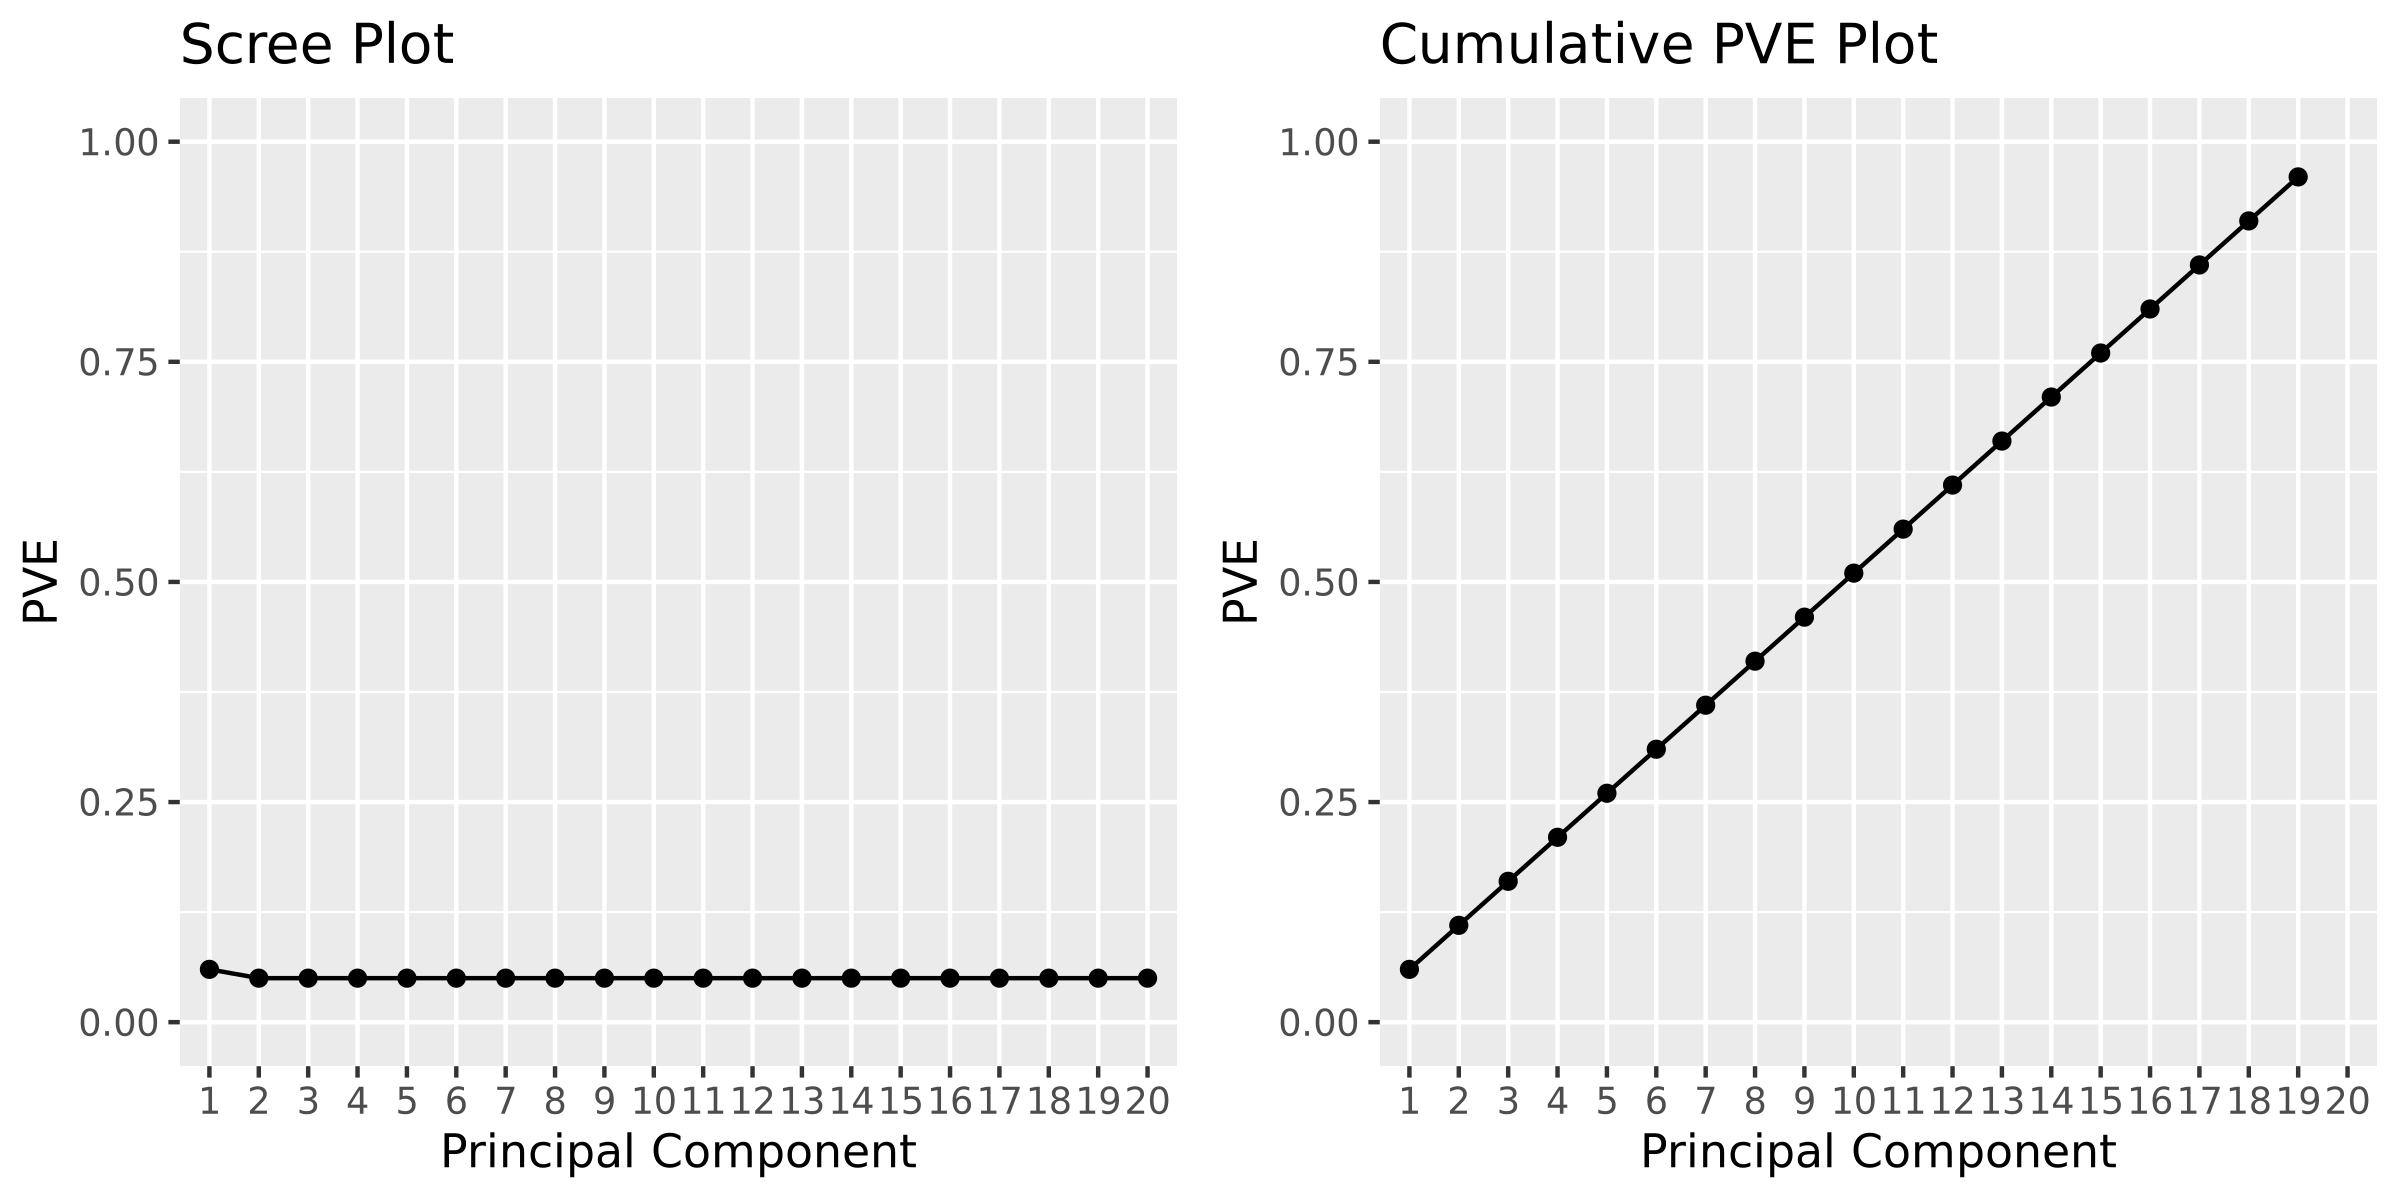

In [15]:
%preview ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.pca.scree.png

### 3.5 Project the related samples into the unrelated PCA space. 

Tip: make sure that you use the genoFile that was generated in step 3.2 and in the pca-model you provide the RDS file generated in step 3.3 when you used only underlated individuals to calculate the PCA.

The maha-k parameter is needed to indicate the number of principal components (PC) that should be used to evaluate outliers. In this case we will use only the 2 first PC's.

In [16]:
sos run ./pipelines/PCA.ipynb project_samples \
  --cwd ./output/pca/ \
  --genoFile ./output/pca/related/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.bed \
  --pca-model ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.unrelated.unrelated_pca.plink_qc.prune.pca.rds \
  --maha-k 2

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running project_samples_1: Project back to PCA model additional samples
INFO: project_samples_1 is completed.
INFO: project_samples_1 output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.pca.projected.rds
INFO: Running project_samples_2: 
INFO: project_samples_2 is completed (pending nested workflow).
INFO: Running detect_outliers: Calculate Mahalanobis distance per population and report outliers
INFO: detect_outliers is completed.
INFO: detect_outliers output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/pca

### 3.6 Visualize outliers

Outliers will be visualized as a red dot. Examine in the outlier files, how many outliers are there?

In [17]:
cat ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.pca.projected.outliers

HG00126	HG00126
HG01509	HG01509


> ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.pca.projected.pc.png (1.2 MiB):

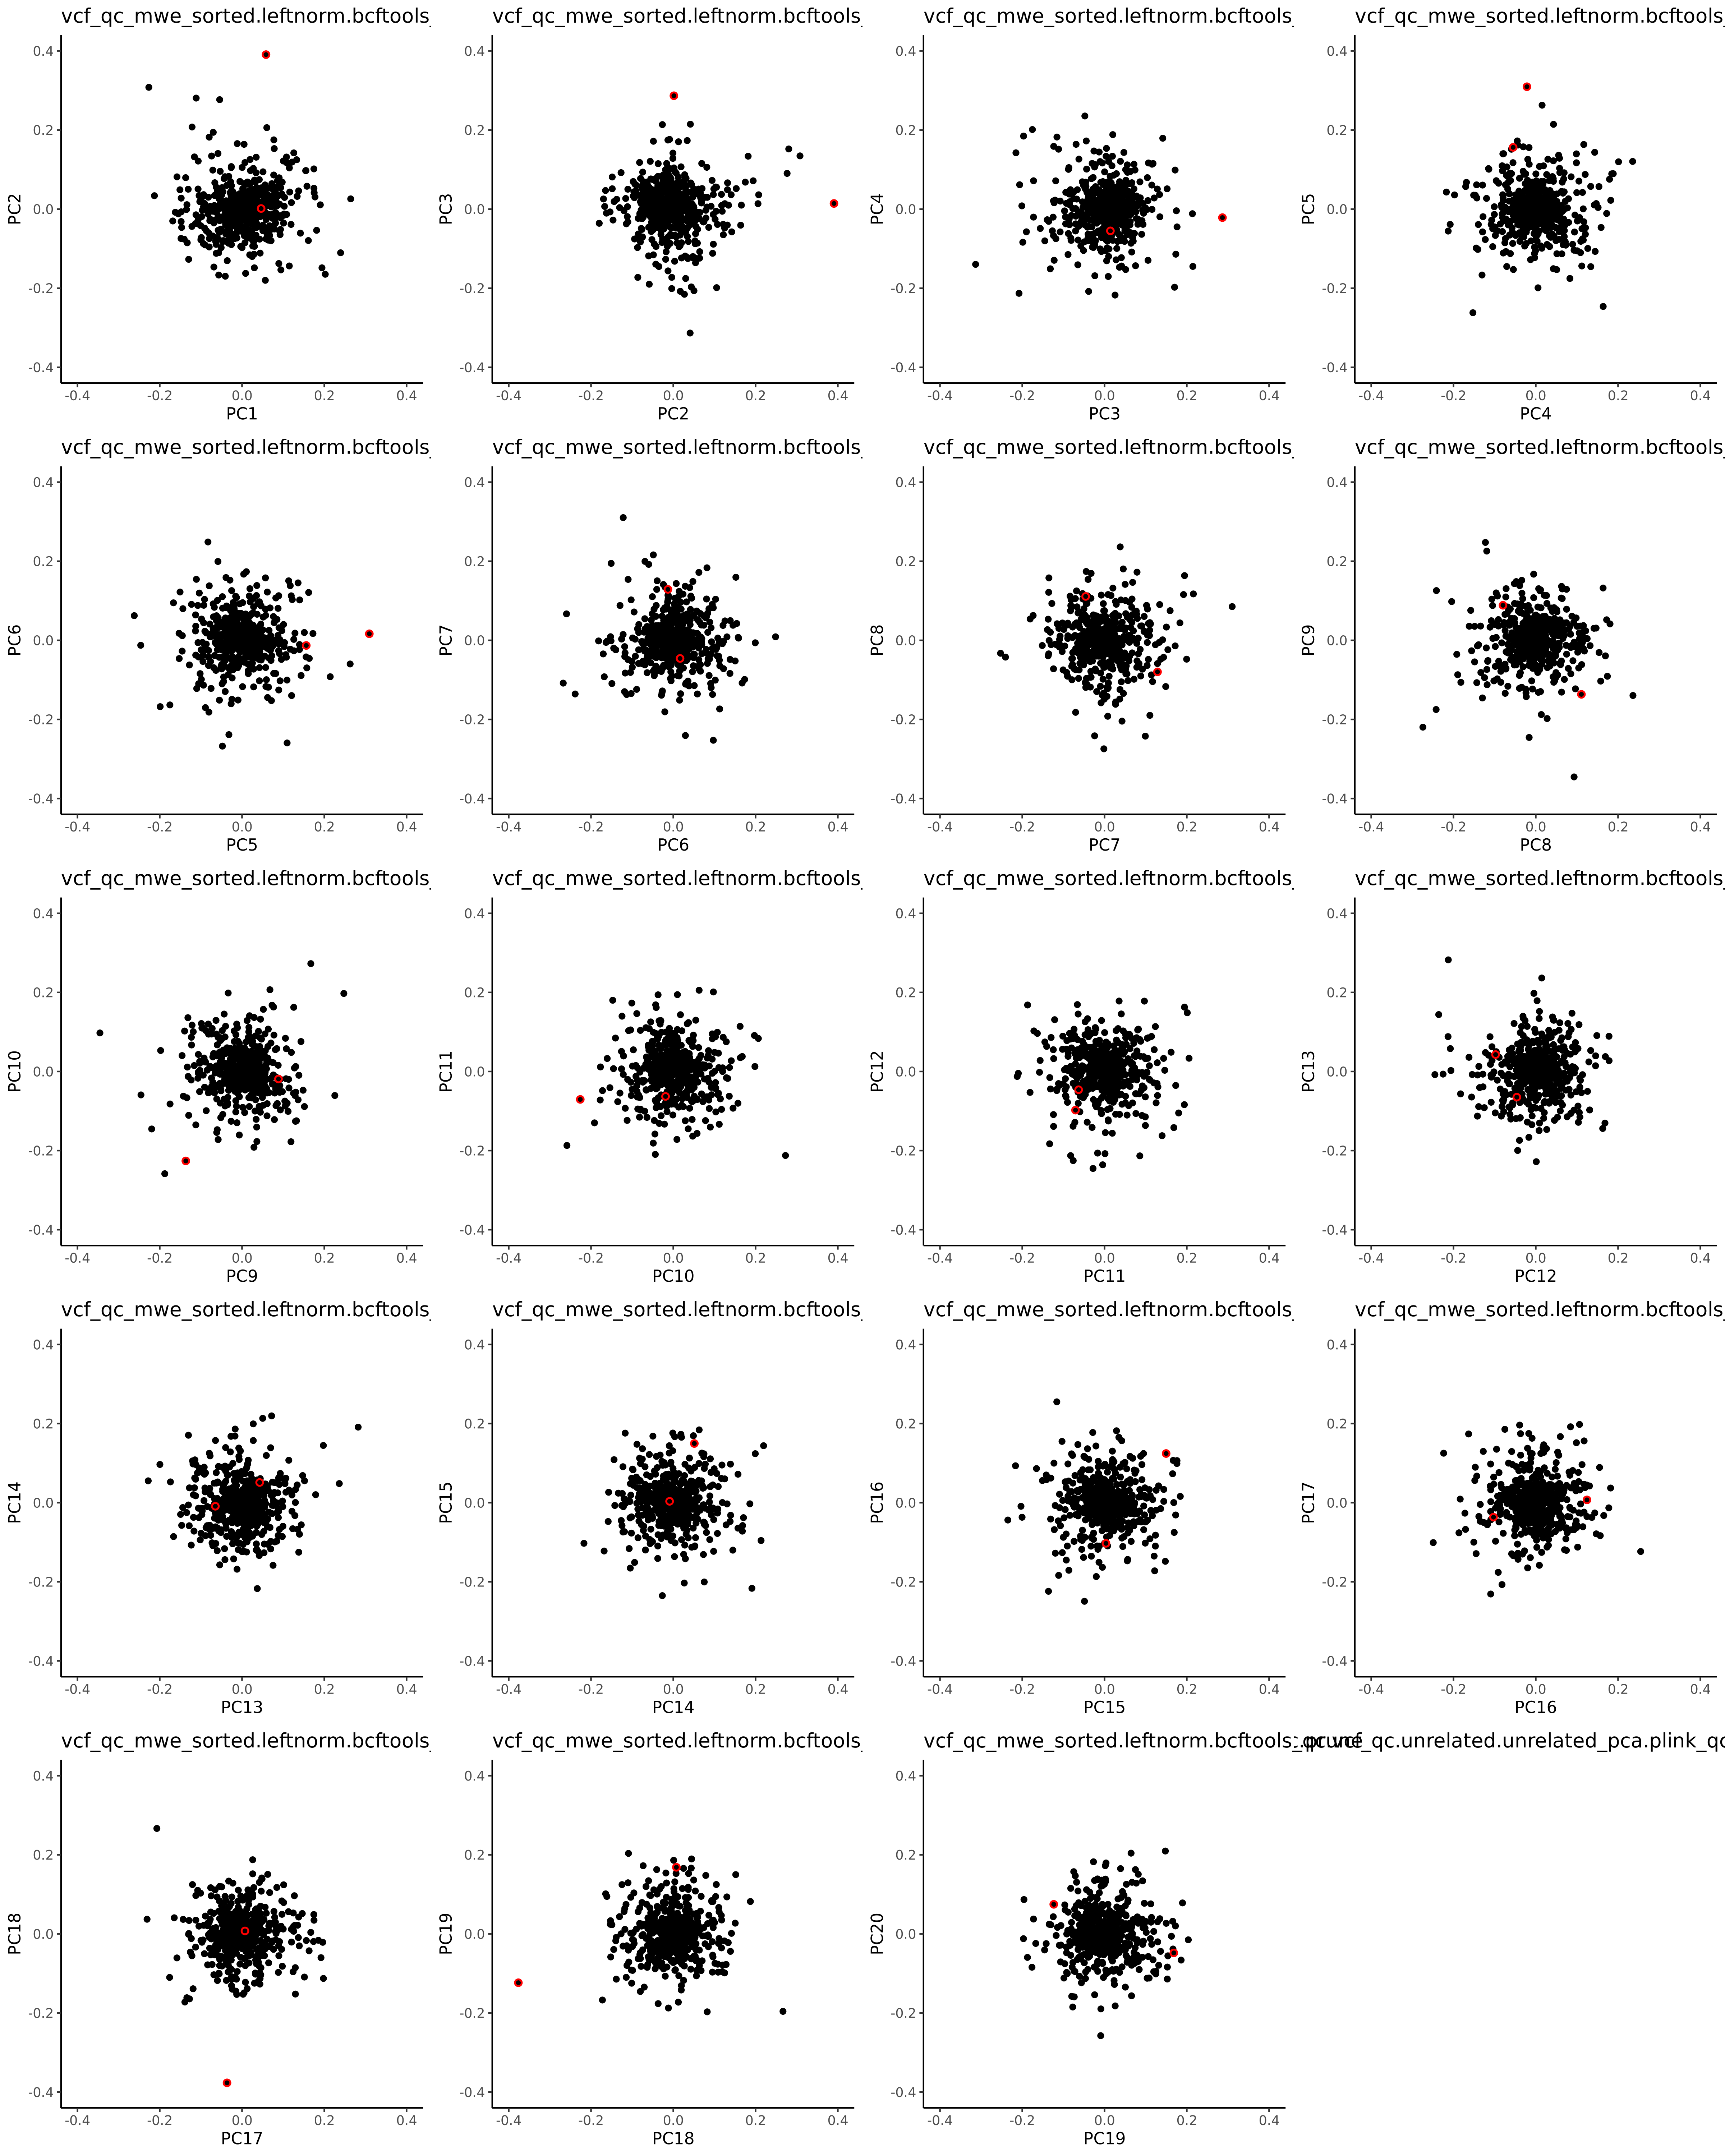

In [18]:
%preview ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.pca.projected.pc.png

### 3.6 Remove outliers from your files

Outliers are removed from the related and unrelated individuals.

Now, remove outliers in the dataset by using the original bed file and using the outlier file obtained in step 3.5

In [19]:
sos run ./pipelines/GWAS_QC.ipynb qc_no_prune \
    --cwd ./output/final_files \
    --genoFile ./output/plink/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.bed \
    --remove-samples ./output/pca/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.pca.projected.outliers \
    --name no_outlier

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running qc_no_prune: Filter SNPs and select individuals
INFO: qc_no_prune is completed.
INFO: qc_no_prune output:   /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/final_files/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.bed
INFO: Workflow qc_no_prune (ID=w56258a6f85339df4) is executed successfully with 1 completed step.


# Step 4. Testing deviation from Hardy Weinberg equilibrium

For each variant, tests for deviation of Hardy Weinberg equilibrium (HWE) can be performed. These tests should only be performed in unrelated individuals from the same ancestry group. Therefore, we perform the test in our unrelated study subjects after removing outliers. If a case-control sample is undergoing QC, then usually tests of HWE are performed in the control group. Various p-values threshold have been used which is partially dependent on the sample size, e.g.    $5 \times 10^{-8}, 1 \times 10^{-15}$

In [20]:
mkdir ./output/hwe/

## extract unrelated individuals
awk '{print $2}' ./output/pca/related/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.fam > ./hwe/related.sample.id
plink \
    --bfile ./output/final_files/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc \
    --remove ./output/pca/related/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.fam \
    --make-bed \
    --out ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated

## recalculate HWE in cleaned unrelated individuals and filter
plink \
    --bfile ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated \
    --hwe 5e-8 \
    --make-bed \
    --out ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.hwe

## extract the same list of variants from the related individuals
plink \
    --bfile ./output/final_files/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc \
    --keep ./output/pca/related/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.fam \
    --extract ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.hwe.bim \
    --make-bed \
    --out ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.related.hwe

bash: ./hwe/related.sample.id: No such file or directory
PLINK v1.9.0-b.8 64-bit (22 Oct 2024)              cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.log.
Options in effect:
  --bfile ./output/final_files/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc
  --make-bed
  --out ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated
  --remove ./output/pca/related/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.vcf_qc.related.related_pca.plink_qc.extracted.fam

15485 MB RAM detected; reserving 7742 MB for main workspace.
32643 variants loaded from .bim file.
532 people (0 males, 0 females, 532 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.nosex
.
--remove: 291 people remaining.
Using 1 thread (no multithreaded calcu

**Question**

How many variants were removed due to failing HWE (p-value < $5.0 \times 10^{-8}$)?

**Answer**

12 variants were removed.

In [21]:
wc -l ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.bim
wc -l ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.hwe.bim

32643 ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.bim
32631 ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.hwe.bim


# Step 5. Evaluating TS/TV Ratios

In [22]:
## merge related and unrelated batches together
mkdir ./output/tstv/

plink \
    --bfile ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.hwe \
    --bmerge ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.related.hwe.bed ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.related.hwe.bim ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.related.hwe.fam \
    --make-bed \
    --recode-vcf bgz \
    --out ./output/tstv/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe

PLINK v1.9.0-b.8 64-bit (22 Oct 2024)              cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode-vcf flag deprecated.  Use "--recode vcf ...".
Logging to ./output/tstv/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe.log.
Options in effect:
  --bfile ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.hwe
  --bmerge ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.related.hwe.bed ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.related.hwe.bim ./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.related.hwe.fam
  --make-bed
  --out ./output/tstv/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe
  --recode vcf bgz

15485 MB RAM detected; reserving 7742 MB for main workspace.
291 people loaded from
./output/hwe/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.unrelated.hwe.fam.
241 p

In [23]:
bcftools stats ./output/tstv/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe.vcf.gz > ./output/tstv/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe.stats

In [24]:
cat ./output/tstv/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe.stats | grep '^TSTV'

TSTV	0	19019	9346	2.03	19019	9346	2.03


**Question**

What is the TS/TV ratio for the entire sample? Provide some reasons why you may observe low TS/TV ratios.

**Answers**

The TS/TV ratio for the entire sample is 2.03.

There are several reasons why you may observe low TS/TV ratios: large number of false positive variants, high genotyping error rates.

# Step 6. Variant annotation using ANNOVAR

Variant annotation should be performed after QC. The annotation will be used for downstream analysis.

A variety of annotation can be obtained for each variant. For example, in ANNOVAR, `func.` annotates the variant to a region, e.g. exonic and classifies it, e.g. missense, splice site. Additional annotation includes but not limited to allele frequencies by ancestry, e.g. gnomAD, functional prediction, e.g. CADD-c score, SIFT, Polyphen, and conservation, e.g. GERP++. For more information look [here](https://annovar.openbioinformatics.org/en/latest/user-guide/gene/). 

In this example we will annotate the gene boundaries and names, variant types, allele frequency based on gnomAD version 4.0 non-Finnish Europeans, and CADD-c score.

In [26]:
sos run ./pipelines/annovar.ipynb annovar \
    --cwd ./output/annovar \
    --bim_name ./output/tstv/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe.bim \
    --humandb ./data/humandb \
    --xref_path ./data/humandb \
    --self_define_protocol True \
    --job_size 1 \
    --build 'hg38' \
    --name_prefix chr21_mwe \
    --container_annovar '' \
    --self_define_protocol True

/mnt/efs/shared/.pixi/envs/python/lib/python3.12/site-packages/sos/targets.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO: Running annovar_1: Create annovar input file
INFO: annovar_1 (index=0) is ignored due to saved signature
INFO: annovar_1 output:   output/annovar/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe.hg38.avinput
INFO: Running annovar_2: Annotate variants file using ANNOVAR
ERROR: annovar_2 (id=b7f35031ec63bac1) returns an error.
ERROR: [annovar_2]: [0]: 
Failed to execute /bin/bash /home/ubuntu/handson-tutorials/contents/ngs_qc_annotation/output/annovar/annovar_2_0_99dac771.sh
exitcode=2, workdir=/home/ubuntu/handson-tutorials/contents/ngs_qc_annotation, stderr=output/annovar/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plin

: 1

**Question**

How many genes are in this region? Do the majority of variants have a MAF < 0.01? What is the highest CADD-c score observed for this region?

In [ ]:
library(dplyr)
library(data.table)

annot <- fread("./output/annovar/vcf_qc_mwe_sorted.leftnorm.bcftools_qc.no_outlier.plink_qc.hwe.hg38.hg38_multianno.csv")

In [ ]:
## number of genes
genes <- lapply(annot$Gene.refGene, function(x) unlist(strsplit(x, ";"))) %>% unlist() %>% unique()
length(genes)

In [ ]:
## number of variants with MAF < 0.01
annot %>% filter(gnomad40_genome_AF_nfe < 0.01) %>% dim()

In [ ]:
## CADD-c score
max_cadd <- annot %>%
  select(CADD_phred) %>%
  mutate(CADD_phred = as.numeric(CADD_phred)) %>% 
  suppressWarnings() %>%  # Suppress warnings
  max(na.rm = TRUE)

max_cadd

annot %>%
  filter(as.numeric(CADD_phred) == max_cadd) %>%
  suppressWarnings()  # Suppress warnings


**Answers**

There are 361 genes in the chromosomal 21 region. A total of 16704 variants have a MAF < 0.01. The highest CADD-c score observed is 37 for an stopgain variant.

# Supplementary

### A. Generation of minimal working example (MWE)

The data was downloaded from the [1000G website](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/). Only 150,000 variants on chromosome 21 will be used for the MWE to ensure that the exercise can be finished in a reasonable amount of time. After downloading the data we will subset the VCF file to contain only the `EUR` samples. To generate the MWE we use `bcftools` software.

**Please note: you do not have to run this part as this is just illustrating how the MWE was created, the data will be given to you ready for analysis**

#### Subset the EUR individuals excluding FIN
Only 534 Europeans individuals from CEU, TSI, GBR and IBS populations (note that we exclude FIN), list available [online](https://www.internationalgenome.org/api/beta/sample/_search/igsr_samples.tsv) and a portion of chr21 will be use for this exercise.

This file is generated from `20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr21.recalibrated_variants.vcf.gz` (downloaded from [here](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20201028_3202_raw_GT_with_annot/)) using the following command: